### Import modules

In [1]:
from zipfile import ZipFile
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.feature import hog
import os
from sklearn.utils import shuffle

%matplotlib inline

### Read images
All images are of size (64, 64, 3)

In [2]:
vehicle_list = []

with ZipFile('data/vehicles.zip', 'r') as zfile:
    name_list = zfile.namelist()
    for fname in name_list:
        fname_split = fname.split(os.sep)
        if fname_split[0] == 'vehicles' and fname.endswith('.png'):
            img = zfile.read(fname)
            img = cv2.imdecode(np.frombuffer(img, np.uint8), 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            vehicle_list.append(img)
            
nonvehicle_list = []
with ZipFile('data/non-vehicles.zip', 'r') as zfile:
    name_list = zfile.namelist()
    for fname in name_list:
        fname_split = fname.split(os.sep)
        if fname_split[0] == 'non-vehicles' and fname.endswith('.png'):
            img = zfile.read(fname)
            img = cv2.imdecode(np.frombuffer(img, np.uint8), 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            nonvehicle_list.append(img)

### Spatial binning

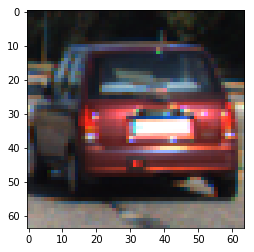

(3072,)

In [3]:
def spatial_bin(img, dsize=(32, 32)):
    img_resized = cv2.resize(img, dsize)
    spatial_feature = img_resized.ravel()
    return spatial_feature

idx = np.random.randint(len(vehicle_list))
img = vehicle_list[idx]
plt.imshow(img)
plt.show()
feature = spatial_bin(img)
feature.shape

### Histogram of color

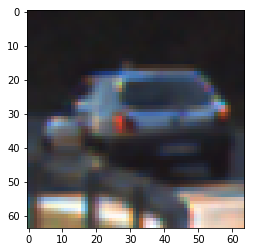

(96,)

In [4]:
def color_hist(img, n_bins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[...,0], bins=n_bins, range=bins_range)
    channel2_hist = np.histogram(img[...,1], bins=n_bins, range=bins_range)
    channel3_hist = np.histogram(img[...,2], bins=n_bins, range=bins_range)
    
    hist_feature = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_feature

idx = np.random.randint(len(vehicle_list))
img = vehicle_list[idx]
plt.imshow(img)
plt.show()
hist_feature = color_hist(img)
hist_feature.shape

### HOG

In [5]:
def calculate_hog(img, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
    hog_feature = []
    for n in range(img.shape[2]):
        hog_feature_tmp = hog(img[...,n], orientations=orientations, pixels_per_cell=pixels_per_cell, 
                              cells_per_block=cells_per_block, block_norm='L2-Hys', 
                              visualise=False, transform_sqrt=True, feature_vector=True)
        hog_feature.append(hog_feature_tmp)
    hog_feature = np.array(hog_feature).ravel()
    return hog_feature

hog_feature = calculate_hog(img)
hog_feature.shape

(8748,)

### Extract all features

In [6]:
def extract_features(image_list, color_space='RGB', spatial_size=(32, 32),
                    n_color_hist_bins=32, color_hist_range=(0, 256)):
    features = []
    for img in image_list:
        if color_space != 'RGB':
            if color_space == 'HSV':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(img)
            
        spatial_feature = spatial_bin(img, dsize=spatial_size)
        color_hist_feature = color_hist(img, n_bins=n_color_hist_bins, 
                                        bins_range=color_hist_range)
        hog_feature = calculate_hog(img)
        features.append(np.concatenate((spatial_feature, color_hist_feature, hog_feature)))
    
    features = np.array(features)
    return features
    
features = extract_features(vehicle_list, 'HSV')
print(features.shape)

(8792, 11916)


### Create data set from images

In [7]:
def create_data(vehicle_list, nonvehicle_list, color_space='HSV', random_state=12983):
    vehicle_features = extract_features(vehicle_list, color_space=color_space)
    nonvehicle_features = extract_features(nonvehicle_list, color_space=color_space)
    x_train = np.concatenate((vehicle_features, nonvehicle_features))
    y_train = np.concatenate((np.ones(vehicle_features.shape[0],), np.zeros(nonvehicle_features.shape[0])))
    x_train, y_train = shuffle(x_train, y_train, random_state=random_state)
    
    return x_train, y_train

x_train, y_train = create_data(vehicle_list, nonvehicle_list)

### Save data set

In [8]:
import pickle 
with open('data.p', 'wb') as pfile:
    pickle.dump({'x_train': x_train, 'y_train': y_train}, pfile, pickle.HIGHEST_PROTOCOL)

#plt.imshow(img)
#plt.show()

img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img_luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

import mpl_toolkits.mplot3d.axes3d as p3


%matplotlib notebook
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.scatter(img_hls[...,0].ravel(), img_hls[...,1].ravel(), img_hls[...,2].ravel(), c=img.reshape(-1, 3)/255.)
ax.set_xlabel('H')
ax.set_ylabel('L')
ax.set_zlabel('S')

%matplotlib inline

In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.15, random_state=321)
print('Train size: {}, validation size: {}, test size: {}'.format(x_train.shape, x_validate.shape, x_test.shape))

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

#random_forest = RandomForestClassifier(n_estimators=100, criterion='entropy', 
#                                       max_depth=15, max_leaf_nodes=80, n_jobs=4, verbose=1)
#random_forest.fit(x_train, y_train)
extra_trees = ExtraTreesClassifier(n_estimators=100, criterion='entropy',
                                  max_depth=15, max_leaf_nodes=80, n_jobs=4, verbose=1)
extra_trees.fit(x_train, y_train)

# the median of feature importance is just 0, so cannot use it or its multiples, can only use mean
# I want to keep 10% of the features, so first calculate the percentile and divided by the mean
p = np.percentile(extra_trees.feature_importances_, 90)/extra_trees.feature_importances_.mean()

model = SelectFromModel(extra_trees, prefit=True, threshold='{:.3f}*mean'.format(p))
x_train0 = model.transform(x_train)
x_train0.shape

Train size: (12076, 11916), validation size: (2132, 11916), test size: (3552, 11916)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.7s finished


(12076, 1192)

In [10]:
from sklearn.feature_selection import RFE


In [11]:
np.percentile(extra_trees.feature_importances_, 90)/extra_trees.feature_importances_.mean()
#extra_trees.feature_importances_.mean()

1.813617040631241

In [12]:
'{:.2f}*mean'.format(p)

'1.81*mean'